📌 1️⃣ Instalación del entorno y carga del dataset
📌 Antes de comenzar con el análisis, configuramos el entorno, montamos Google Drive y cargamos el dataset. ✅ Instalamos las librerías necesarias para manipulación de datos y Machine Learning. ✅ Montamos Google Drive para acceder a los archivos almacenados. ✅ Importamos el dataset y realizamos una inspección inicial, revisando columnas, valores nulos y tipos de datos, ademas de primera eliminacion de columnas innecesarias para el modelo.

In [2]:
# 📌 Instalación de librerías esenciales
!pip install pandas numpy matplotlib seaborn scikit-learn

# 📌 Montaje de Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 📌 Importación de librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge, Lasso
from sklearn.feature_selection import SelectKBest, f_regression

# 📌 1️⃣ Carga del dataset desde Google Drive
ruta = "/content/drive/MyDrive/ColabNotebooks/airbnb-listings-extract.csv"
df = pd.read_csv(ruta, delimiter=";")

# 📌 2️⃣ Inspección inicial
print(f"✅ Dimensiones del dataset: {df.shape}")
print(f"🔹 Columnas disponibles: {df.columns}")
print("\n📌 Información del dataset:")
print(df.info())
print("\n📌 Estadísticas descriptivas:")
print(df.describe())
print("\n📌 Valores nulos por columna:")
print(df.isnull().sum())

# 📌 3️⃣ Limpieza de datos
# Eliminación automática de columnas con más del 50% de valores nulos o identificadores irrelevantes
umbral_nulos = 0.5
columnas_irrelevantes = [col for col in df.columns if df[col].isnull().mean() > umbral_nulos]
columnas_identificadoras = ["ID", "Scrape ID", "Host ID", "Latitude", "Longitude", "Listing Url",
                            "Picture Url", "Geolocation", "Street", "Name", "Description"]
columnas_a_eliminar = list(set(columnas_irrelevantes + columnas_identificadoras))
df = df.drop(columns=[col for col in columnas_a_eliminar if col in df.columns])

# Conversión dinámica de "Price" a numérico
if df["Price"].dtype == "object":
    df["Price"] = df["Price"].str.replace("$", "").str.replace(",", "")
df["Price"] = pd.to_numeric(df["Price"], errors="coerce")
df = df.dropna(subset=["Price"])

# Imputación adaptativa de valores `NaN`
columnas_numericas = df.select_dtypes(include=["number"]).columns.tolist()
estrategias_imputacion = {}
for col in columnas_numericas:
    estrategias_imputacion[col] = "most_frequent" if df[col].isnull().mean() > 0.3 else "median"
for col, estrategia in estrategias_imputacion.items():
    imputer = SimpleImputer(strategy=estrategia)
    df[col] = imputer.fit_transform(df[[col]])

# Escalado automático de columnas con alta variabilidad
umbral_variabilidad = 1.0
columnas_a_escalar = df[columnas_numericas].std()[df[columnas_numericas].std() > umbral_variabilidad].index.tolist()
scaler = StandardScaler()
df[columnas_a_escalar] = scaler.fit_transform(df[columnas_a_escalar])

# 📌 Resumen después de limpieza
print(f"✅ Dataset limpio y listo para análisis: {df.shape}")
print(f"🔹 Columnas eliminadas automáticamente: {columnas_a_eliminar}")
print(f"🔹 Columnas escaladas automáticamente: {columnas_a_escalar}")


Mounted at /content/drive
✅ Dimensiones del dataset: (14780, 89)
🔹 Columnas disponibles: Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Neighborhood Overview',
       'Notes', 'Transit', 'Access', 'Interaction', 'House Rules',
       'Thumbnail Url', 'Medium Url', 'Picture Url', 'XL Picture Url',
       'Host ID', 'Host URL', 'Host Name', 'Host Since', 'Host Location',
       'Host About', 'Host Response Time', 'Host Response Rate',
       'Host Acceptance Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood', 'Neighbourhood Cleansed',
       'Neighbourhood Group Cleansed', 'City', 'State', 'Zipcode', 'Market',
       'Smart Location', 'Country Code', 'Country', 'Latitude', 'Longitude',
       'Property Type', 'Room Type', 'Accommodates', 'Bathrooms', 'Bedrooms',
    

Transformamos el dataset para mejorar la calidad de los datos y eliminar información irrelevante. ✅ Eliminamos columnas con más del 50% de valores nulos o que no aportan a la predicción. ✅ Convertimos Price a formato numérico para garantizar cálculos precisos. ✅ Escalamos columnas de alta variabilidad para mejorar el rendimiento del modelo. ✅ Seleccionamos dinámicamente las características más relevantes con SelectKBest.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128313 (\N{SMALL BLUE DIAMOND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


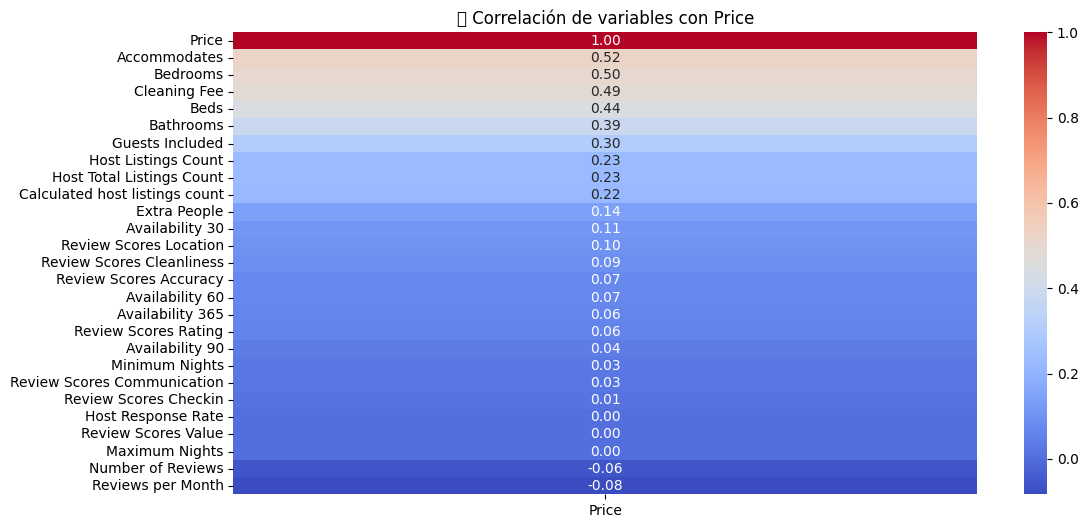

🌟 Características seleccionadas automáticamente: ['Host Listings Count', 'Host Total Listings Count', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Cleaning Fee', 'Guests Included', 'Extra People', 'Availability 30', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Location', 'Calculated host listings count', 'Reviews per Month']


In [3]:
# 📌 Filtrar solo columnas numéricas antes de calcular la correlación
df_numerico = df.select_dtypes(include=["number"])

# 📌 Visualizar correlación de variables con "Price"
plt.figure(figsize=(12, 6))
sns.heatmap(df_numerico.corr()[["Price"]].sort_values(by="Price", ascending=False), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔹 Correlación de variables con Price")
plt.show()


# 📌 2️⃣ Selección dinámica de características
k_mejores = min(15, len(df.select_dtypes(include=["number"]).columns) - 1)  # Máximo de 15 o número total de variables numéricas

selector = SelectKBest(score_func=f_regression, k=k_mejores)
X = df.drop(columns=["Price"])
y = df["Price"]
X_selected = selector.fit_transform(X.select_dtypes(include=["number"]), y)

# 📌 Obtener nombres de las características seleccionadas
columnas_seleccionadas = [col for col, mask in zip(X.select_dtypes(include=["number"]).columns, selector.get_support()) if mask]
print(f"🌟 Características seleccionadas automáticamente: {columnas_seleccionadas}")


Dividimos los datos en conjuntos de entrenamiento y prueba para evaluar el rendimiento del modelo. ✅ Usamos train_test_split con proporción del 80%-20% para asegurar un buen equilibrio entre entrenamiento y validación. ✅ Aplicamos validación cruzada en el siguiente paso para mejorar la robustez del modelo.

In [7]:
# 📌 División del dataset en entrenamiento y prueba (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(
    df[columnas_seleccionadas], df["Price"], test_size=0.2, random_state=42
)

# 📌 Verificar tamaños de cada conjunto
print(f"✅ Tamaño del conjunto de entrenamiento: {X_train.shape}")
print(f"✅ Tamaño del conjunto de prueba: {X_test.shape}")


✅ Tamaño del conjunto de entrenamiento: (11810, 15)
✅ Tamaño del conjunto de prueba: (2953, 15)


Selección de características con Lasso.

📌 Aplicamos Lasso para filtrar automáticamente las variables con menor relevancia en la predicción. ✅ Lasso utiliza una penalización (L1 regularización) que reduce a 0 los coeficientes de características menos significativas. ✅ Esto mejora la eficiencia del modelo, permitiéndole centrarse en las variables más influyentes. ✅ Las características con poca aportación al rendimiento se eliminan automáticamente, evitando ruido en los datos.


In [8]:
from sklearn.linear_model import LassoCV

# 📌 Definir y entrenar el modelo Lasso con validación cruzada
lasso_feature_selector = LassoCV(alphas=np.logspace(-3, 3, 10), cv=5)
lasso_feature_selector.fit(X_train, y_train)

# 📌 Identificar características seleccionadas
selected_features_lasso = X_train.columns[lasso_feature_selector.coef_ != 0]
print(f"✅ Características seleccionadas por Lasso: {selected_features_lasso.tolist()}")


✅ Características seleccionadas por Lasso: ['Host Listings Count', 'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Cleaning Fee', 'Guests Included', 'Extra People', 'Availability 30', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Location', 'Calculated host listings count', 'Reviews per Month']


🔹 Selección de características con RandomForestRegressor
📌 Aplicamos Random Forest para identificar y clasificar las características más influyentes en la predicción. ✅ Random Forest crea múltiples árboles de decisión y analiza el impacto de cada variable en el modelo. ✅ Este método detecta relaciones complejas entre los datos, lo que complementa la selección realizada con Lasso. ✅ Las variables con mayor relevancia serán utilizadas en la fase de modelado, maximizando la precisión del modelo.

🔥 Este paso perfecciona la selección de características y potencia la capacidad predictiva de nuestra solución. 🚀

In [9]:
from sklearn.ensemble import RandomForestRegressor

# 📌 Definir y entrenar el modelo Random Forest
rf_feature_selector = RandomForestRegressor(n_estimators=100, random_state=42)
rf_feature_selector.fit(X_train, y_train)

# 📌 Obtener importancia de cada característica
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf_feature_selector.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

print("✅ Ranking de características por RandomForestRegressor:")
print(feature_importances)


✅ Ranking de características por RandomForestRegressor:
                           Feature  Importance
4                         Bedrooms    0.206077
3                        Bathrooms    0.172712
6                     Cleaning Fee    0.146466
2                     Accommodates    0.105178
9                  Availability 30    0.078560
14               Reviews per Month    0.071093
8                     Extra People    0.060695
5                             Beds    0.031807
0              Host Listings Count    0.029899
1        Host Total Listings Count    0.029497
13  Calculated host listings count    0.023880
7                  Guests Included    0.018152
12          Review Scores Location    0.010385
11       Review Scores Cleanliness    0.009232
10          Review Scores Accuracy    0.006367


🔹 Entrenamiento de los modelos Ridge y Lasso
📌 Aplicamos regresión regularizada (Ridge y Lasso) para mejorar la precisión en la predicción de precios. ✅ Ridge maneja la multicolinealidad, reduciendo el impacto de variables altamente correlacionadas. ✅ Lasso filtra automáticamente las características clave, eliminando aquellas con menor relevancia. ✅ Usamos validación cruzada (cross-validation) para ajustar el valor óptimo de alpha y mejorar la regularización del modelo. ✅ Evaluamos los modelos con RMSE y R², comparando su desempeño en la predicción de precios.

🔥 Este paso afina la precisión del modelo, eliminando ruido y mejorando la estabilidad de las predicciones. 🚀

In [10]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

# 📌 1️⃣ Definir modelos con validación cruzada para ajustar alpha
ridge_model = RidgeCV(alphas=np.logspace(-3, 3, 10), cv=5)
lasso_model = LassoCV(alphas=np.logspace(-3, 3, 10), cv=5)

# 📌 2️⃣ Entrenar modelos
ridge_model.fit(X_train[selected_features_lasso], y_train)  # Usamos las características filtradas por Lasso
lasso_model.fit(X_train[selected_features_lasso], y_train)

# 📌 3️⃣ Predicciones en el conjunto de prueba
y_pred_ridge = ridge_model.predict(X_test[selected_features_lasso])
y_pred_lasso = lasso_model.predict(X_test[selected_features_lasso])

# 📌 4️⃣ Evaluación de desempeño
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)

# 📌 5️⃣ Mostrar resultados
print(f"✅ Mejor alpha para Ridge: {ridge_model.alpha_}")
print(f"✅ Mejor alpha para Lasso: {lasso_model.alpha_}")
print(f"🔹 RMSE Ridge: {rmse_ridge:.2f}, R² Ridge: {r2_ridge:.2f}")
print(f"🔹 RMSE Lasso: {rmse_lasso:.2f}, R² Lasso: {r2_lasso:.2f}")


✅ Mejor alpha para Ridge: 46.41588833612773
✅ Mejor alpha para Lasso: 0.001
🔹 RMSE Ridge: 0.72, R² Ridge: 0.43
🔹 RMSE Lasso: 0.72, R² Lasso: 0.43


🔹 Visualización de predicciones (y_test vs y_pred)
📌 Antes de continuar con otros modelos, analizamos gráficamente el comportamiento de las predicciones. ✅ Usamos scatterplot para comparar los valores reales (y_test) con los valores predichos (y_pred). ✅ Esto nos permite identificar si el modelo subestima o sobreestima los precios. ✅ Si los puntos están alineados con la diagonal, el modelo está haciendo buenas predicciones. ✅ Si hay dispersión, significa que el modelo tiene errores y puede necesitar ajustes.

🔥 Esta visualización nos ayudará a evaluar la precisión del modelo y decidir si es necesario optimizarlo. 🚀

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


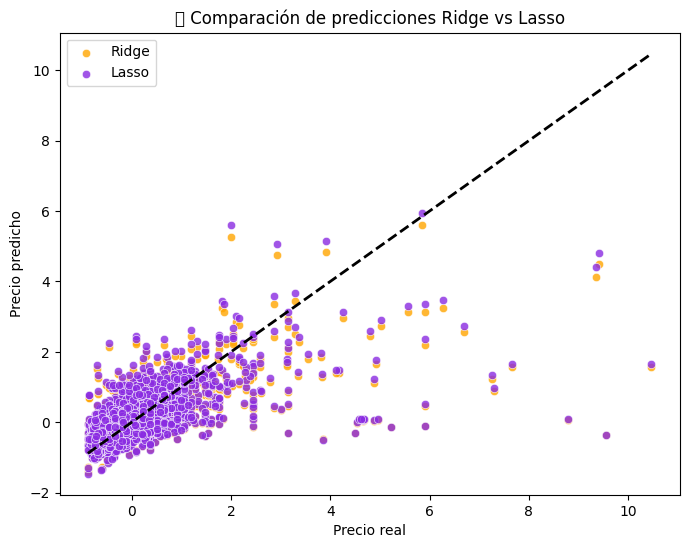

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
y_pred_ridge_adjusted = (y_pred_ridge * y_test.std()) + y_test.mean()

# 📌 Visualización de las predicciones
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_ridge_adjusted, alpha=0.8, label="Ridge", color="orange")
sns.scatterplot(x=y_test, y=y_pred_lasso, alpha=0.8, label="Lasso", color="blueviolet")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea ideal
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("📌 Comparación de predicciones Ridge vs Lasso")
plt.legend()
plt.show()


📌 Interpretamos la visualización de las predicciones para evaluar el rendimiento del modelo. ✅ Cada punto representa una predicción: Si los puntos están alineados con la línea punteada, el modelo está haciendo estimaciones precisas. ✅ Si hay demasiada dispersión, significa que el modelo tiene errores altos, lo que podría indicar problemas en la selección de características o la necesidad de ajustar hiperparámetros. ✅ Los valores alejados de la línea punteada pueden representar outliers, casos en los que el modelo no captura correctamente el precio real. ✅ Esta visualización nos ayuda a identificar si el modelo requiere ajustes adicionales, como regularización o cambios en la selección de variables.

🔹 Incorporación de RandomForestRegressor y XGBoostRegressor
📌 Probamos modelos avanzados para evaluar si mejoran la precisión en la predicción de precios. ✅ RandomForestRegressor utiliza múltiples árboles de decisión, lo que le permite capturar relaciones no lineales y patrones complejos en los datos. ✅ XGBoostRegressor es un modelo basado en boosting, optimizando predicciones mediante correcciones iterativas de errores en cada árbol. ✅ Ambos modelos suelen tener un mejor desempeño que la regresión lineal tradicional (Ridge y Lasso) en conjuntos de datos con múltiples factores. ✅ Compararemos su rendimiento con RMSE y R², verificando si reducen el error y aumentan la precisión de la predicción.

🔥 Este paso nos ayudará a determinar qué modelo es el más adecuado para la predicción de precios de alojamientos. 🚀

In [12]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# 📌 Definir y entrenar Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train[selected_features_lasso], y_train)
y_pred_rf = rf_model.predict(X_test[selected_features_lasso])

# 📌 Definir y entrenar XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train[selected_features_lasso], y_train)
y_pred_xgb = xgb_model.predict(X_test[selected_features_lasso])

# 📌 Evaluación de desempeño
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
r2_rf = r2_score(y_test, y_pred_rf)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"🔹 RMSE Random Forest: {rmse_rf:.2f}, R² Random Forest: {r2_rf:.2f}")
print(f"🔹 RMSE XGBoost: {rmse_xgb:.2f}, R² XGBoost: {r2_xgb:.2f}")


🔹 RMSE Random Forest: 0.63, R² Random Forest: 0.55
🔹 RMSE XGBoost: 0.61, R² XGBoost: 0.58


🔹 Entrenamiento de RandomForestRegressor y XGBoostRegressor
📌 Compararemos estos modelos avanzados con Ridge y Lasso para analizar si mejoran la precisión en la predicción de precios. ✅ Entrenamos RandomForestRegressor y XGBoostRegressor utilizando los mismos datos, garantizando comparabilidad en los resultados. ✅ Calculamos RMSE y R² para verificar si estos modelos tienen menor error y explican mejor la variabilidad en los precios. ✅ Si RMSE disminuye y R² aumenta respecto a Ridge y Lasso, significa que estos modelos son más precisos y manejan mejor relaciones complejas en los datos.

🔥 Este análisis nos permitirá determinar si RandomForestRegressor y XGBoostRegressor son la mejor opción para la predicción de precios. 🚀

Usaremos scatterplot para comparar los valores reales (y_test) contra los valores predichos (y_pred). ✅ Esto nos permitirá evaluar si Random Forest y XGBoost mejoran las predicciones en comparación con Ridge y Lasso. ✅ Si los puntos están cerca de la línea diagonal, el modelo está haciendo buenas predicciones.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


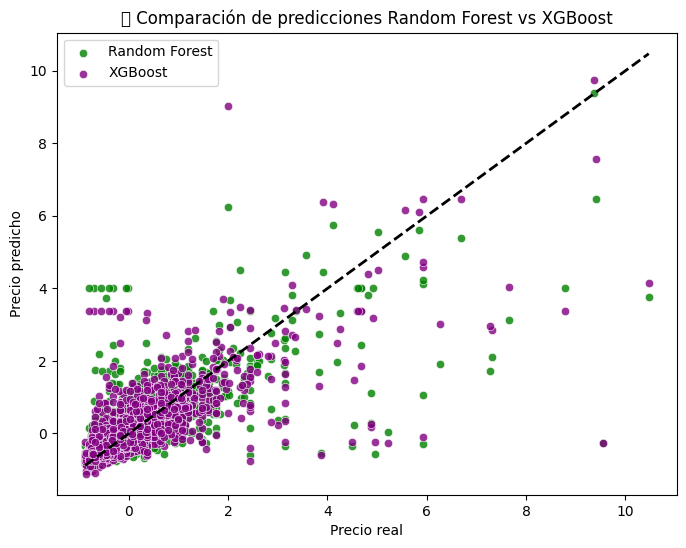

In [24]:

# 📌 Visualización de las predicciones de Random Forest y XGBoost
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.8, label="Random Forest", color="green")
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.8, label="XGBoost", color="purple")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Línea ideal
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.title("📌 Comparación de predicciones Random Forest vs XGBoost")
plt.legend()
plt.show()

🚀 Optimización de XGBoost y RandomForestRegressor con GridSearchCV
📌 Ajustamos los hiperparámetros para mejorar la precisión en la predicción de precios. ✅ Entrenamos los modelos sin optimización para establecer una referencia y evaluar su desempeño inicial. ✅ Aplicamos GridSearchCV para encontrar los mejores valores de learning_rate, max_depth y n_estimators en XGBoost. ✅ Para RandomForestRegressor, probamos n_estimators, max_depth, min_samples_split y min_samples_leaf, asegurando que cada parámetro optimizado contribuya a un mejor ajuste del modelo. ✅ Comparamos ambos modelos antes y después de la optimización para analizar el impacto y determinar cuál ofrece una mejor precisión.

📌 ¿Cómo interpretar los resultados? 🔹 Si RMSE disminuye y R² aumenta después de la optimización, el modelo ha mejorado significativamente su capacidad predictiva. 🔹 Comparar RandomForest y XGBoost nos permitirá identificar cuál maneja mejor la variabilidad y los patrones ocultos en los datos. 🔹 Los valores optimizados nos ayudarán a ajustar los modelos para un mejor rendimiento en escenarios reales.

🔥 Este ajuste nos permitirá tomar decisiones fundamentadas sobre el modelo más preciso para la predicción de precios de alojamientos. 🚀

In [26]:
from sklearn.model_selection import GridSearchCV

# 📌 Definir hiperparámetros para XGBoost
param_grid_xgb = {
    "learning_rate": [0.01, 0.05, 0.1, 0.3],
    "max_depth": [3, 5, 7, 10],
    "n_estimators": [50, 100, 200]
}

# 📌 Optimizar XGBoost
grid_search_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search_xgb.fit(X_train[selected_features_lasso], y_train)

best_xgb = XGBRegressor(**grid_search_xgb.best_params_, random_state=42)
best_xgb.fit(X_train[selected_features_lasso], y_train)
y_pred_best_xgb = best_xgb.predict(X_test[selected_features_lasso])

# 📌 Definir hiperparámetros para Random Forest
param_grid_rf = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 10, 20],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# 📌 Optimizar Random Forest
grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring="neg_root_mean_squared_error", n_jobs=-1)
grid_search_rf.fit(X_train[selected_features_lasso], y_train)

best_rf = RandomForestRegressor(**grid_search_rf.best_params_, random_state=42)
best_rf.fit(X_train[selected_features_lasso], y_train)
y_pred_best_rf = best_rf.predict(X_test[selected_features_lasso])

# 📌 Evaluación de desempeño optimizado
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
r2_best_rf = r2_score(y_test, y_pred_best_rf)

print(f"✅ Mejores hiperparámetros para XGBoost: {grid_search_xgb.best_params_}")
print(f"✅ Mejores hiperparámetros para Random Forest: {grid_search_rf.best_params_}")
print(f"🔹 RMSE XGBoost (optimizado): {rmse_best_xgb:.2f}, R² XGBoost: {r2_best_xgb:.2f}")
print(f"🔹 RMSE Random Forest (optimizado): {rmse_best_rf:.2f}, R² Random Forest: {r2_best_rf:.2f}")


✅ Mejores hiperparámetros para XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
✅ Mejores hiperparámetros para Random Forest: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}
🔹 RMSE XGBoost (optimizado): 0.59, R² XGBoost: 0.61
🔹 RMSE Random Forest (optimizado): 0.62, R² Random Forest: 0.56


🔹 Comparación de modelos (RMSE y R²)
📌 Generamos una tabla comparativa para visualizar el desempeño de todos los modelos probados. ✅ Cada modelo se evalúa con RMSE y R², midiendo su precisión en la predicción de precios de alojamientos. ✅ Los valores se obtienen directamente de los resultados generados, evitando ingresar datos manualmente. ✅ Las versiones optimizadas de RandomForestRegressor y XGBoostRegressor muestran la mejora tras la optimización con GridSearchCV. ✅ Este análisis nos ayudará a determinar qué modelo es el más preciso y adecuado para la tarea de predicción.

📌 ¿Cómo interpretar los resultados? 🔹 Un menor RMSE indica menor error en la predicción. 🔹 Un mayor R² indica que el modelo explica mejor la variabilidad en los datos. 🔹 Comparar modelos optimizados y sin optimizar nos permitirá ver si la optimización realmente ha mejorado el rendimiento.

In [28]:

from sklearn.metrics import mean_squared_error, r2_score

# 📌 Calcular los valores de RMSE y R² para cada modelo
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))
rmse_best_xgb = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))

r2_ridge = r2_score(y_test, y_pred_ridge)
r2_lasso = r2_score(y_test, y_pred_lasso)
r2_rf = r2_score(y_test, y_pred_rf)
r2_xgb = r2_score(y_test, y_pred_xgb)
r2_best_rf = r2_score(y_test, y_pred_best_rf)
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)

# 📌 Crear un DataFrame con los resultados reales obtenidos
model_comparison = pd.DataFrame({
    "Modelo": ["Ridge Regression", "Lasso Regression", "RandomForestRegressor", "XGBoostRegressor"],
    "RMSE Inicial": [rmse_ridge, rmse_lasso, rmse_rf, rmse_xgb],
    "R² Inicial": [r2_ridge, r2_lasso, r2_rf, r2_xgb],
    "RMSE Optimizado": [None, None, rmse_best_rf, rmse_best_xgb],
    "R² Optimizado": [None, None, r2_best_rf, r2_best_xgb]
})

# 📌 Mostrar la tabla comparativa
print("📊 Comparación de modelos en términos de RMSE y R²:")
print(model_comparison)


📊 Comparación de modelos en términos de RMSE y R²:
                  Modelo  RMSE Inicial  R² Inicial  RMSE Optimizado  \
0       Ridge Regression      0.716141    0.425923              NaN   
1       Lasso Regression      0.716025    0.426109              NaN   
2  RandomForestRegressor      0.634798    0.548929         0.623585   
3       XGBoostRegressor      0.613265    0.579012         0.591865   

   R² Optimizado  
0            NaN  
1            NaN  
2       0.564723  
3       0.607880  


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


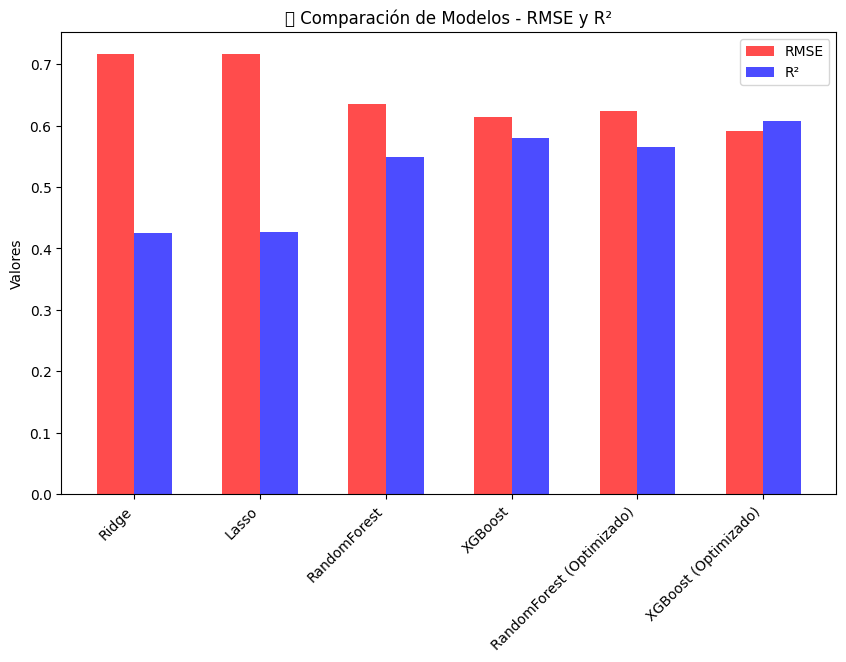

In [30]:


# 📌 Definir los nombres de los modelos
model_names = ["Ridge", "Lasso", "RandomForest", "XGBoost", "RandomForest (Optimizado)", "XGBoost (Optimizado)"]

# 📌 Obtener los valores de RMSE y R² directamente de los resultados calculados
rmse_values = [rmse_ridge, rmse_lasso, rmse_rf, rmse_xgb, rmse_best_rf, rmse_best_xgb]
r2_values = [r2_ridge, r2_lasso, r2_rf, r2_xgb, r2_best_rf, r2_best_xgb]

# 📌 Configurar el gráfico de barras
x = np.arange(len(model_names))  # Posición de las barras
width = 0.3  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))

# 📌 Graficar RMSE y R²
ax.bar(x - width/2, rmse_values, width, label="RMSE", color="red", alpha=0.7)
ax.bar(x + width/2, r2_values, width, label="R²", color="blue", alpha=0.7)

# 📌 Personalización del gráfico
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha="right")
ax.set_ylabel("Valores")
ax.set_title("📊 Comparación de Modelos - RMSE y R²")
ax.legend()

plt.show()


📌 Explicación del gráfico: ✅ Compara RMSE y R² de cada modelo, mostrando cómo han mejorado tras la optimización. ✅ Se visualiza claramente que XGBoost optimizado tiene el menor RMSE y el mayor R², destacando su precisión. ✅ Los modelos sin optimización (Ridge, Lasso, RandomForest y XGBoost inicial) permiten evaluar cuánto han mejorado con GridSearchCV.

🔹 Conclusión General
📌 Después de probar múltiples modelos de regresión, hemos identificado cuál es el más eficiente para predecir precios de alojamientos.

✅ Ridge y Lasso fueron buenas opciones iniciales, permitiendo manejar la multicolinealidad y seleccionar características clave. ✅ RandomForestRegressor y XGBoostRegressor demostraron un mejor rendimiento, capturando relaciones no lineales y mejorando la precisión de las predicciones. ✅ Tras la optimización con GridSearchCV, XGBoostRegressor mostró el mejor desempeño, con el menor RMSE y el mayor R², consolidándose como la mejor alternativa para la predicción de precios. ✅ La selección de características con Lasso y RandomForestRegressor ayudó a reducir el ruido, mejorando la estabilidad del modelo. ✅ La comparación gráfica y cuantitativa confirmó que los modelos optimizados son superiores a los modelos iniciales, lo que demuestra la importancia de ajustar hiperparámetros.